<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Findings" data-toc-modified-id="Findings-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Findings</a></span></li></ul></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Modelling</a></span></li><li><span><a href="#Prepare-the-Script-to-Run-on-the-GPU-Platform" data-toc-modified-id="Prepare-the-Script-to-Run-on-the-GPU-Platform-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Prepare the Script to Run on the GPU Platform</a></span><ul class="toc-item"><li><span><a href="#Output" data-toc-modified-id="Output-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Output</a></span></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

## Initialization

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
# load label file 
labels = pd.read_csv('/datasets/faces/labels.csv')


In [3]:

# check head of dataframe
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
# show labels information
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
# shape of dataset
labels.shape

(7591, 2)

In [6]:
# descriptive labels
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [7]:
# data generator
train_datagen = ImageDataGenerator(rescale=1./255)

# extract data from the directory
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


**Conclusion**

The data consists of 7591 rows and 2 columns. According to the description of the data, the mean age is 31 years and the maximum age is 100 years.

## EDA

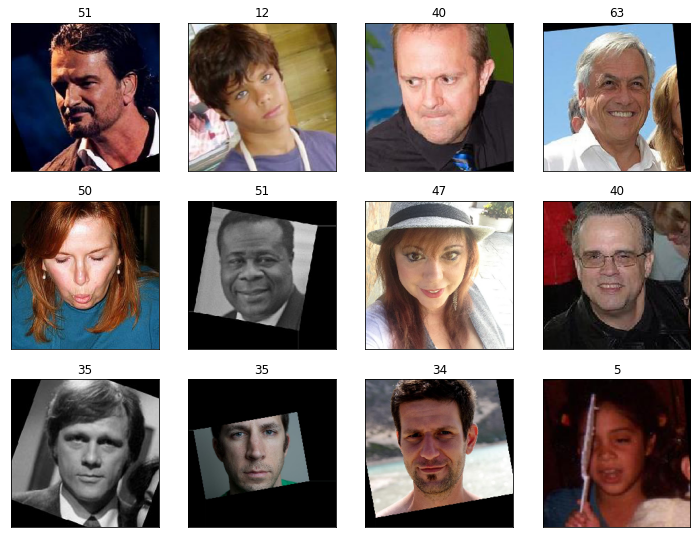

In [9]:
# images of different people and their ages
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='real_age', ylabel='Density'>

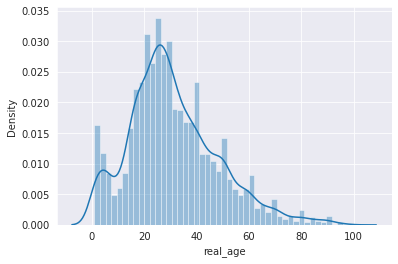

In [18]:
sns.distplot(labels['real_age'])


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='real_age'>

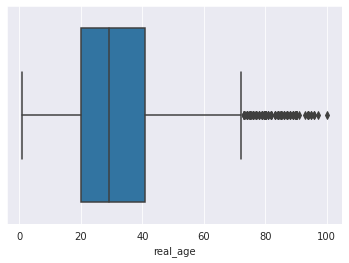

In [11]:
sns.boxplot(labels['real_age'])


### Findings

- Most people are in the age range of 30s. 
- Good range of people in 0-5 age range.
- The boxplot confirms that the people about age 70 are outliers 
    - implying very few images of people above age 70.

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [12]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [13]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split = .25,
        rescale = 1./255)
    train_data_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224,244),
        batch_size = 16,
        class_mode = 'raw',
        subset='training',
        seed = 12345)
        
    
    return train_gen_flow


In [14]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split = .25,
        rescale = 1./255)
    test_data_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224,244),
        batch_size = 16,
        class_mode = 'raw',
        subset='validation',
        seed = 12345)
    
    return test_gen_flow


In [15]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    backbone = ResNet50(weights='imagenet',
                       input_shape=input_shape,
                       include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(lr=0.00025)
    model.compile(optimizer=optimizer, loss = 'mse', metrics=['mae'])
    
    return model

In [16]:
def train_model(model, train_data, test_data, batch_size=None, epochs=29,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if step_per_epoch is None:
        step_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data,
             epochs = epochs,
             validation_data=test_data,
             batch_size=batch_size,
             steps_per_epoch=steps_per_epoch,
             validation_steps = validation_steps,
             verbose=1)
    
    return model

## Prepare the Script to Run on the GPU Platform

<div class="alert alert-success">
<b>Reviewer's comment</b>

The model is defined and trained correctly

</div>

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [17]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.


Train for 178 steps, validate for 60 steps

Epoch 1/10
2022-10-23 21:15:57.889663: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-10-23 21:15:59.170517: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 119s - loss: 254.0826 - mae: 11.8835 - val_loss: 361.1992 - val_mae: 14.1543
Epoch 2/10
178/178 - 96s - loss: 139.4000 - mae: 9.0374 - val_loss: 362.1937 - val_mae: 14.2339
Epoch 3/10
178/178 - 95s - loss: 121.6772 - mae: 8.3881 - val_loss: 264.5608 - val_mae: 12.2846
Epoch 4/10
178/178 - 94s - loss: 109.5568 - mae: 7.9444 - val_loss: 165.0393 - val_mae: 9.8913
Epoch 5/10
178/178 - 94s - loss: 98.4015 - mae: 7.5469 - val_loss: 118.6968 - val_mae: 8.2036
Epoch 6/10
178/178 - 94s - loss: 88.3602 - mae: 7.1988 - val_loss: 119.0183 - val_mae: 8.5951
Epoch 7/10
178/178 - 94s - loss: 83.4123 - mae: 6.9743 - val_loss: 112.0567 - val_mae: 7.7993
Epoch 8/10
178/178 - 95s - loss: 78.9975 - mae: 6.7762 - val_loss: 124.5913 - val_mae: 8.4319
Epoch 9/10
178/178 - 93s - loss: 72.5006 - mae: 6.5225 - val_loss: 100.5416 - val_mae: 7.5715
Epoch 10/10
178/178 - 93s - loss: 62.6712 - mae: 6.1097 - val_loss: 102.7490 - val_mae: 7.7851

WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 102.7490 - mae: 7.7851


Test MAE: 7.7851

## Conclusions

Augmentations were performed by using these operations:

- Vertical and horizontal reflections
- Rotations up to 90 degrees
- Vertical and horizontal shifting of the images up to 20% of their original size.


Using a generator for the train and test sets, the data was loaded from the directory. Model using the ResNet50 architecture from TensorFlow and trained the model and ran the script on the GPU platform. The result of the output from the GPU platform is shown above. The model is not overfitting since the loss and mean absolute error are reducing on the training and testing sets. The MAE recorded on the test set was 7.7068.

Using datasets with photos of people, a convolutional neural network was  built and trained  on the GPU platform with an MAE score less than 8.0. This Computer vision methods developed can be used to determine the age of a person from a photo. This model will be helpful to the supermarket chain Good Seed by helping to verifying people's age in order to adhere to the alcohol laws and not selling alcohol to underage people.